Found 7697 images belonging to 355 classes.
Found 3560 images belonging to 355 classes.
Epoch 1/750
240/240 [==============================] - 64s 239ms/step - loss: 5.8708 - accuracy: 0.0078 - val_loss: 5.8659 - val_accuracy: 0.0084
Epoch 2/750
240/240 [==============================] - 49s 205ms/step - loss: 5.8648 - accuracy: 0.0093 - val_loss: 5.8605 - val_accuracy: 0.0084
Epoch 3/750
240/240 [==============================] - 49s 202ms/step - loss: 5.8582 - accuracy: 0.0090 - val_loss: 5.8527 - val_accuracy: 0.0084
Epoch 4/750
240/240 [==============================] - 47s 196ms/step - loss: 5.8507 - accuracy: 0.0097 - val_loss: 5.8470 - val_accuracy: 0.0076
Epoch 5/750
240/240 [==============================] - 48s 201ms/step - loss: 5.8421 - accuracy: 0.0120 - val_loss: 5.8363 - val_accuracy: 0.0096
Epoch 6/750
240/240 [==============================] - 48s 201ms/step - loss: 5.7929 - accuracy: 0.0150 - val_loss: 5.7897 - val_accuracy: 0.0132
Epoch 7/750
240/240 [===============

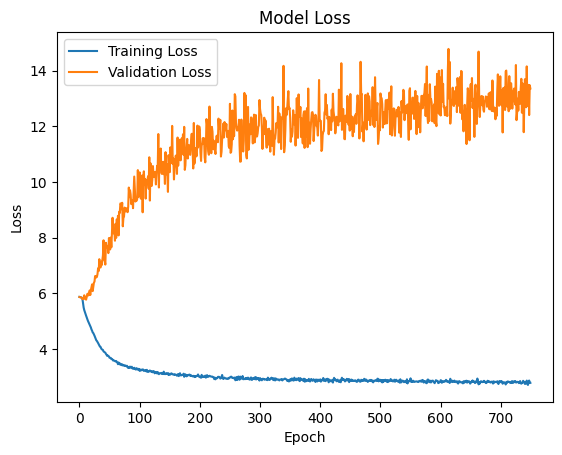

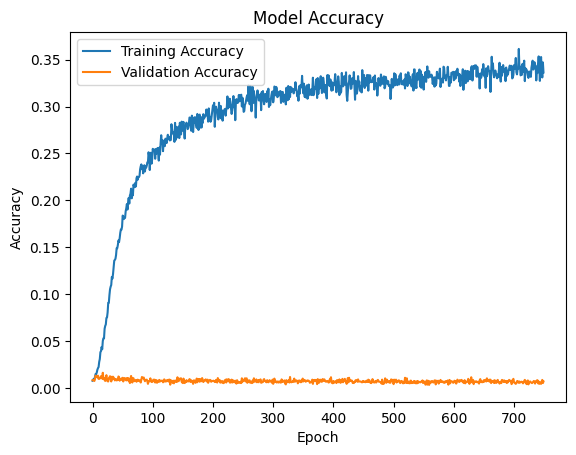

112/112 [==============================] - 13s 110ms/step
Accuracy: 0.007022471910112359
Average Precision: 0.013385084948783483
Average Recall: 0.007103428652724428
Average F1 Score: 0.007155370610871418


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
# Define data directories
train_data_dir = r"C:\Users\79894\Downloads\archive2_converted_train"
test_data_dir = r"C:\Users\79894\Downloads\archive2_converted_test"

# Define data generators with preprocessing_function (fixed image size)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda img: crop_dog(img, [10, 10, 100, 100])  # Pass the bounding box here
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of preprocessed images
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(32, 32),  # Adjusted to match LeNet input shape
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(32, 32),  # Adjusted to match LeNet input shape
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# Function to crop dog from image using bounding box
def crop_dog(img, bbox, target_size=(32, 32)):
    x_min, y_min, width, height = bbox
    cropped_img = img[y_min:y_min+height, x_min:x_min+width]
    resized_img = resize(cropped_img, target_size, anti_aliasing=True)
    return resized_img
    
# Define the LeNet model architecture
model = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(355, activation='softmax')  # Adjust output neurons based on your classification task
])

# Compile the model
model.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train your model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=750,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Extract results from the final epoch
final_epoch_results = {
    'loss': history.history['loss'][-1],
    'accuracy': history.history['accuracy'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_accuracy': history.history['val_accuracy'][-1]
}

# Print the final epoch results
print("Final Epoch Results:")
print(final_epoch_results)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on test data
validation_generator.reset()  # Reset the generator to start from the beginning
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, predicted_classes)

# Calculate metrics
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

precision = []
recall = []
f1_score = []

for i in range(355):  # Adjusted based on the number of classes
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision_i = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall_i = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    precision.append(precision_i)
    recall.append(recall_i)

    # Calculate F1 score
    if precision_i + recall_i != 0:
        f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
    else:
        f1_score_i = 0

    f1_score.append(f1_score_i)

# Calculate average precision, recall, and F1 score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# Print the metrics
print("Accuracy:", accuracy)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1_score)


In [3]:
pip install scikit-image

   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/24.5 MB 1.3 MB/s eta 0:00:19
   ---------------------------------------- 0.1/24.5 MB 787.7 kB/s eta 0:00:32
   ---------------------------------------- 0.2/24.5 MB 1.2 MB/s eta 0:00:21
   ---------------------------------------- 0.2/24.5 MB 1.3 MB/s eta 0:00:19
    --------------------------------------- 0.5/24.5 MB 2.0 MB/s eta 0:00:12
    --------------------------------------- 0.5/24.5 MB 2.0 MB/s eta 0:00:13
   - -------------------------------------- 1.0/24.5 MB 3.1 MB/s eta 0:00:08
   - -------------------------------------- 1.1/24.5 MB 3.1 MB/s eta 0:00:08
   --- ------------------------------------ 2.0/24.5 MB 4.9 MB/s eta 0:00:05
   --- ------------------------------------ 2.3/24.5 MB 5.0 MB/s eta 0:00:05
   ----- ---------------------------------- 3.1/24.5 MB 6.1 MB/s eta 0:00:04
   ------- -------------------------------- 4.3/24.5 MB 8.2 MB/s eta 0:00:03
   -